# Model Evaluation

In this section we will measure the various model's ability to predict unseen samples (our labelled validation/test data)

F1-scores will be used to evaluate our models. This is a much better way to measure accuracy than the simple 'accuracy' metric which is a far more basic measure that does not neccessarily reflect some inaccuries in the model's performance as it assumes that the dataset is symetrical and balanced. F1 Scores are the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. A weighted F1-score will be used in this case as this combines the model's recall/precision scores and gives a weighted average from the 'support' value for each label which is more useful given our uneven dataset distribution (all words are equal however as our models evaluate unknown vs the 10 key command words this unbalances the categories in terms of cost)

In [41]:
import numpy as np
import numpy.random as nr
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import to_categorical, plot_model
from keras import backend as K
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
from sklearn import svm, preprocessing


In [213]:
# The code was removed by Watson Studio for sharing.

In [4]:
from ibm_botocore.client import Config
import ibm_boto3
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials_1['ENDPOINT'])

In [29]:
cos.download_file(Bucket=credentials_1['BUCKET'],Key='RESNET.h5',Filename='models/RESNET.h5')
cos.download_file(Bucket=credentials_1['BUCKET'],Key='resnet8_16_32_VAD_2701_last.h5',Filename='models/resnet8_16_32_VAD_2701_last.h5')
cos.download_file(Bucket=credentials_1['BUCKET'],Key='Neural_Network_trained.sav',Filename='models/Neural_Network_trained.sav')
cos.download_file(Bucket=credentials_1['BUCKET'],Key='svm_trained.sav',Filename='models/svm_trained.sav')

In [ ]:
cos.download_file(Filename='data/X_train_mfcc.npy',Bucket=credentials_1['BUCKET'],Key='X_train_mfcc.npy')
cos.download_file(Filename='data/Y_train_mfcc.npy',Bucket=credentials_1['BUCKET'],Key='Y_train_mfcc.npy')
cos.download_file(Filename='data/Y_train_mfcc_all.npy',Bucket=credentials_1['BUCKET'],Key='Y_train_mfcc_all.npy')
cos.download_file(Filename='data/X_val_mfcc.npy',Bucket=credentials_1['BUCKET'],Key='X_val_mfcc.npy')
cos.download_file(Filename='data/Y_val_mfcc.npy',Bucket=credentials_1['BUCKET'],Key='Y_val_mfcc.npy')
cos.download_file(Filename='data/Y_val_mfcc_all.npy',Bucket=credentials_1['BUCKET'],Key='Y_val_mfcc_all.npy')

cos.download_file(Filename='data/X_train_fft.npy',Bucket=credentials_1['BUCKET'],Key='X_train_fft.npy')
cos.download_file(Filename='data/Y_train_fft.npy',Bucket=credentials_1['BUCKET'],Key='Y_train_fft.npy')
cos.download_file(Filename='data/Y_train_all_fft.npy',Bucket=credentials_1['BUCKET'],Key='Y_train_fft_all.npy')
cos.download_file(Filename='data/X_val_fft.npy',Bucket=credentials_1['BUCKET'],Key='X_val_fft.npy')
cos.download_file(Filename='data/Y_val_fft.npy',Bucket=credentials_1['BUCKET'],Key='Y_val_fft.npy')
cos.download_file(Filename='data/Y_val_all_fft.npy',Bucket=credentials_1['BUCKET'],Key='Y_val_fft_all.npy')

cos.download_file(Filename='data/X_train.npy',Bucket=credentials_1['BUCKET'],Key='X_train.npy')
cos.download_file(Filename='data/Y_train.npy',Bucket=credentials_1['BUCKET'],Key='Y_train.npy')
cos.download_file(Filename='data/Y_train_all.npy',Bucket=credentials_1['BUCKET'],Key='Y_train_all.npy')
cos.download_file(Filename='data/X_val.npy',Bucket=credentials_1['BUCKET'],Key='X_val.npy')
cos.download_file(Filename='data/Y_val.npy',Bucket=credentials_1['BUCKET'],Key='Y_val.npy')
cos.download_file(Filename='data/Y_val_all.npy',Bucket=credentials_1['BUCKET'],Key='Y_train_all.npy')

# SVM evaluation
First we load the FFT data to be used by the SVM model

In [7]:
X_train = np.load('./data/X_train_fft.npy')
Y_train = np.load('./data/Y_train_fft.npy')
X_test = np.load('./data/X_val_fft.npy')
y_test = np.load('./data/Y_val_fft.npy')

Just as in training we will scale the X_test values as SVMs perform better with scaled data.

In [11]:
scale = preprocessing.StandardScaler()
scale.fit(X_test)
X_test = scale.transform(X_test)

In [175]:
filename = './models/svm_trained.sav'
svm_mod = pickle.load(open(filename,'rb'))
scores_svm = svm_mod.predict(X_test)

In [176]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'unknown']


def print_metrics_3(labels, scores):
    print('confusion matrix')
    conf = confusion_matrix(labels, scores, )
    print(conf)
    accuracy_score(labels, scores)
    print(classification_report(labels, scores, target_names=classes, digits = 3))
print_metrics_3(y_test, scores_svm)


confusion matrix
[[  85    1    0    0    4    6    2    3   19    1  140]
 [   2   46    6   14    4    4   16    4    2   12  160]
 [   0    6   42    2   14    0   25   24   10    2  135]
 [   4   13    6   16    4   14    9    2    1    4  191]
 [   6    8    7    2   18    2    3    0    6    8  187]
 [   8    9    2   12    7   19    0    2    3   10  184]
 [   0    9   17    5    0    1   86   43    2    5   89]
 [   1    3   18    0    2    2   20  142    8    0   60]
 [   6    1   12    3    3    1    6   19   74    1  120]
 [   1   14   10    0    6    7    5    4    4   45  164]
 [ 327  169  103   72   80  127   92  132  143  139 2837]]
              precision    recall  f1-score   support

         yes      0.193     0.326     0.243       261
          no      0.165     0.170     0.168       270
          up      0.188     0.162     0.174       260
        down      0.127     0.061     0.082       264
        left      0.127     0.073     0.093       247
       right      0

As we can see from the results we get a poor F1-Score, which reflects the poor accuracy and recall of the model. The weighted F1-score is 0.494 for all labels. While this is a multi-class problem we should still expect far better results than this. 

Below we can see exactly which words have been misclassified, even the command words that are fairly different such as left and up are being confused regularly nevermind the unknown utterances! Whilst this model could be improved by optimizing it further, with such a low baseline score it seems better to move on and find a better model to start with. 

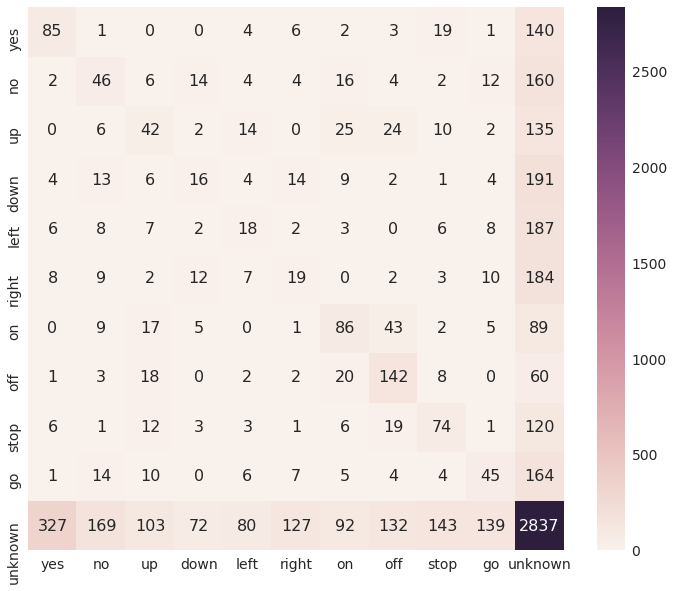

In [177]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_test, scores_svm)       
df_cm_svm = pd.DataFrame(array, index=classes,
                  columns=classes)
plt.figure(figsize = (12,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm_svm, annot=df_cm_svm.astype(int) ,annot_kws={"size": 16}, fmt='d')# font size
plt.savefig('graphs/confmatSVM.png', bbox_inches='tight')

# MLP Evaluation
Our MLP Neural network should perform better

In [30]:
filename = './models/Neural_Network_trained.sav'
nn_mod = pickle.load(open(filename,'rb'))
scores = nn_mod.predict(X_test)

In [182]:
scores_mlp = nn_mod.predict(X_test)

In [183]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'unknown']


def print_metrics_3(labels, scores):
    print('confusion matrix')
    conf = confusion_matrix(labels, scores, )
    print(conf)
    accuracy_score(labels, scores)
    print(classification_report(labels, scores, target_names=classes, digits = 3))
print_metrics_3(y_test, scores_mlp)

confusion matrix
[[  47    1    0    5   12    8    1    2    7    5  173]
 [   1   50   10   11   23    6   16    2    2   23  126]
 [   0    5   71    2   20    1    7   16   35   14   89]
 [   5    9    4   32   15   16    4    1    5   10  163]
 [   7   24   17    3   65    7    4    3    8   13   96]
 [   4    3    4   18    4   48    1    0    8   11  155]
 [   0    8    4    0    3    3   87   28    7    4  113]
 [   0    1   15    1    3    0   27  122   18    1   68]
 [   3    1   20    3    5    3    6   10   85    3  107]
 [   0   14    6    7    5   11    5    6    6   94  106]
 [ 119   85   84  117  109  135   80   72  138  131 3151]]
              precision    recall  f1-score   support

         yes      0.253     0.180     0.210       261
          no      0.249     0.185     0.212       270
          up      0.302     0.273     0.287       260
        down      0.161     0.121     0.138       264
        left      0.246     0.263     0.254       247
       right      0

It does, but by a suprisingly low amount, here we have a weighted F1-Score of just 0.561 which only just beats the SVM and by less than .10. We are moving in the right direction but theres still a long way to go. It seems that these methods are too simple to evaluate the complex data in speech audio files. Time to try a deep neural network

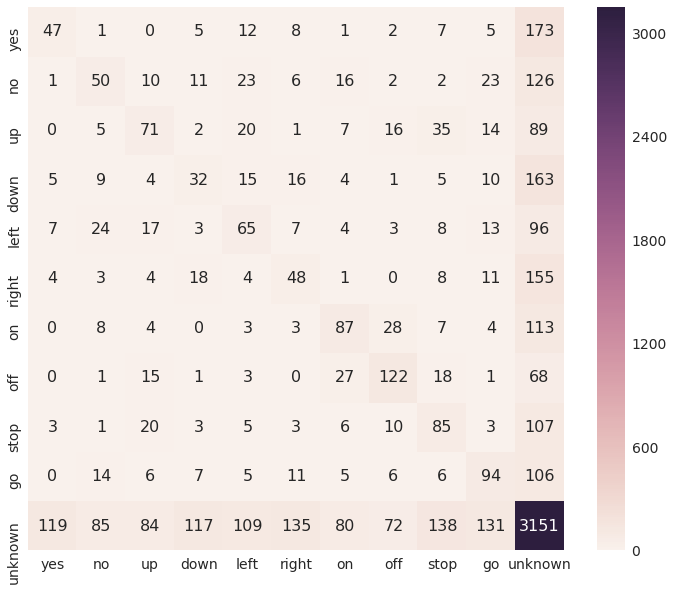

In [185]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_test, scores_mlp)       
df_cm_mlp = pd.DataFrame(array, index=classes,
                  columns=classes)
plt.figure(figsize = (12,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm_mlp, annot=df_cm_mlp.astype(int) ,annot_kws={"size": 16}, fmt='d')# font size
plt.savefig('graphs/confmatMLP.png', bbox_inches='tight')

# Deep ResNet Evaluation
The deep resnet will evaluate the audio data more directly as mel-spectrograms and this should produce more complex features and far better results.

In [238]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'unknown']

In [239]:
X_train = np.load ('./data/X_train.npy')
Y_train = np.load('./data/Y_train.npy')
X_val = np.load ('./data/X_val.npy')
Y_val = np.load('./data/Y_val.npy')

In [240]:
from keras.models import load_model
sr = load_model('./models/RESNET.h5')
sr.load_weights('./models/resnet8_16_32_Final_0102_last.h5')
batch_size = 196
val_pred = sr.predict(X_val, batch_size = batch_size, verbose = 1)

6798/6798 [==============================] - 19s 3ms/step


In [241]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

              precision    recall  f1-score   support

         yes      0.982     0.858     0.916       261
          no      0.974     0.700     0.815       270
          up      0.976     0.781     0.868       260
        down      0.922     0.902     0.912       264
        left      0.964     0.968     0.966       247
       right      0.902     0.969     0.934       256
          on      0.954     0.724     0.823       257
         off      0.976     0.805     0.882       256
        stop      0.763     0.967     0.853       246
          go      0.858     0.862     0.860       260
     unknown      0.937     0.979     0.958      4221

   micro avg      0.931     0.931     0.931      6798
   macro avg      0.928     0.865     0.890      6798
weighted avg      0.934     0.931     0.929      6798



Finally, we have a network that is performing well. Suddenly we are achieving scores of 90+% accuracy and a very closely correlated level of recall gives a weighted f1-score of 93%. The confusion matrix plotted below also shows that almost no command words (except those with similar sounding phonemes) are being confused and most of the confusion lies with the unknown words. I believe it would be possible to boost this model further through hyperparameter optimization and regulation. However, given the time constraints of this project these were the best obtainable results.

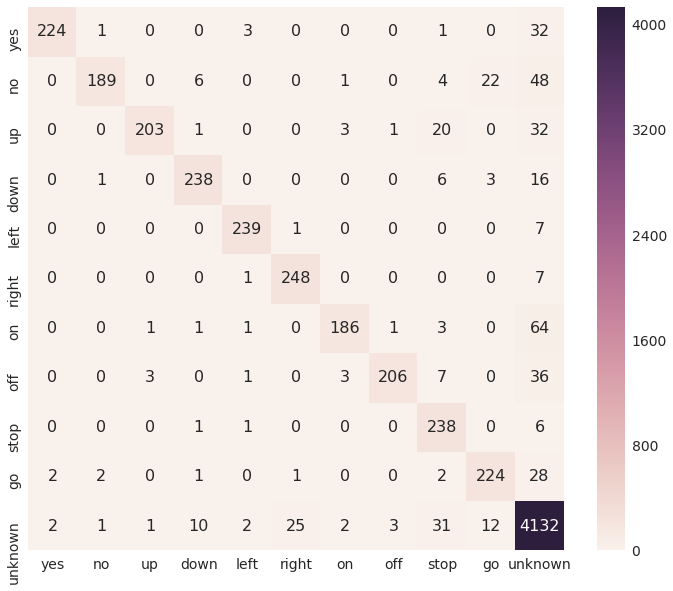

In [242]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(Y_val,np.argmax(val_pred, axis=1))       
df_cm = pd.DataFrame(array, index=classes,
                  columns=classes)
plt.figure(figsize = (12,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=df_cm.astype(int) ,annot_kws={"size": 16}, fmt='d')# font size
plt.savefig('graphs/confmatRES.png', bbox_inches='tight')

## Additional Iteration
As required an additional Feature Creation element for the model was added and evaluated. This involved the creation of MFCC spectrograms which have fewer features than mel-log spectrograms.

In [226]:
X_train = np.load ('./data/X_train_mfcc.npy')
Y_train = np.load('./data/Y_train_mfcc.npy')
X_val = np.load ('./data/X_val_mfcc.npy')
Y_val = np.load('./data/Y_val_mfcc.npy')

In [227]:
from keras.models import load_model
sr = load_model('./models/RESNET_MFCC.h5')
sr.load_weights('./models/RESNET_MFCC_0202_best.h5')
batch_size = 196
val_pred = sr.predict(X_val, batch_size = batch_size, verbose = 1)

6839/6839 [==============================] - 4s 616us/step


In [228]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'unknown']
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes , digits = 3))

              precision    recall  f1-score   support

         yes      0.914     0.893     0.903       261
          no      0.778     0.507     0.614       270
          up      0.603     0.892     0.719       260
        down      0.442     0.830     0.576       264
        left      0.917     0.765     0.834       247
       right      0.852     0.809     0.830       256
          on      0.765     0.774     0.770       257
         off      0.887     0.832     0.859       256
        stop      0.783     0.882     0.830       246
          go      0.369     0.823     0.510       260
     unknown      0.953     0.832     0.888      4262

   micro avg      0.820     0.820     0.820      6839
   macro avg      0.751     0.804     0.758      6839
weighted avg      0.869     0.820     0.833      6839



The MFCC model performs well but not quite as well as the mel-log spectrogram model. Clearly in this case fewer features does not mean a better model. For data of this complexity we lose too much information in MFCC spectrograms.

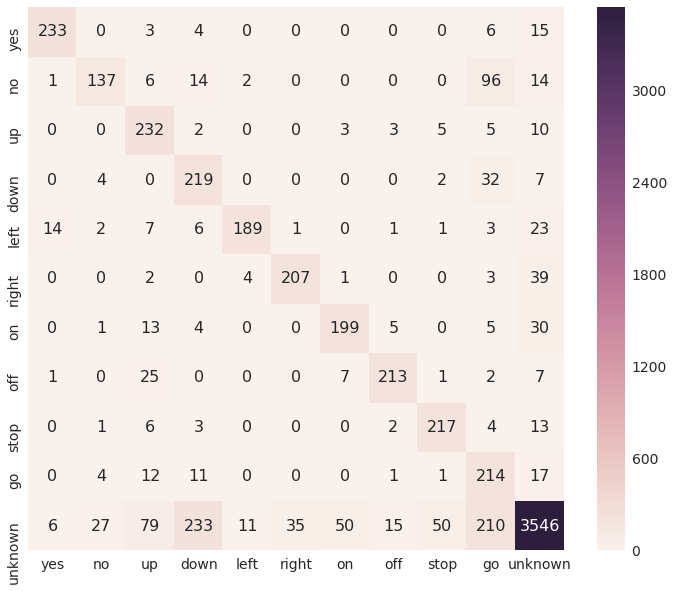

In [229]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(Y_val,np.argmax(val_pred, axis=1))       
df_cm = pd.DataFrame(array, index=classes,
                  columns=classes)
plt.figure(figsize = (12,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=df_cm.astype(int) ,annot_kws={"size": 16}, fmt='d')# font size
plt.savefig('graphs/confmatRES_MFCC.png', bbox_inches='tight')

This function was used to create dataframes of the classification reports which were then used to create a csv of each models report.

In [189]:
from collections import defaultdict
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data


In [173]:
crres=pd.DataFrame(report2dict(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))).T

In [230]:
crresmfcc=pd.DataFrame(report2dict(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))).T

In [ ]:
crsvm=pd.DataFrame(report2dict(classification_report(y_test, scores_svm, target_names=classes, digits = 3))).T

In [186]:
crmlp=pd.DataFrame(report2dict(classification_report(y_test, scores_mlp, target_names=classes, digits = 3))).T

In [235]:
crsvm.to_csv('graphs/crsvm.csv', index=True)

In [233]:
crres.to_csv('graphs/crres.csv', index=True)

In [234]:
crmlp.to_csv('graphs/crmlp.csv', index=True)

In [236]:
crresmfcc.to_csv('graphs/crresmfcc.csv', index=True)

In [190]:
cos.upload_file(Filename='graphs/crsvm.csv',Bucket=credentials_1['BUCKET'],Key='crsvm.csv')
cos.upload_file(Filename='graphs/crres.csv',Bucket=credentials_1['BUCKET'],Key='crres.csv')
cos.upload_file(Filename='graphs/crmlp.csv',Bucket=credentials_1['BUCKET'],Key='crmlp.csv')
cos.upload_file(Filename='graphs/crresmfcc.csv',Bucket=credentials_1['BUCKET'],Key='crresmfcc.csv')